# Gradient Descent For Logistic Regression
## Handwritten digit recognition

In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy.linalg import norm

In [1]:
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

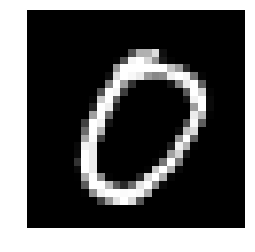

In [62]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
y = mnist.target
X = mnist.data.astype('float64')
np.random.shuffle(X)
show_digit(X[1])

In [63]:
print (X[1].reshape(28,28))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  80.
  175. 176. 219.  16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.  82. 244.
  254. 213. 144.  26.   4.   0.   0.   0.   0.   0.   0.  

In [64]:
# IMPORTANT since the 0th column of X is 1's we will NOT scale the 0th column. (Hint: set mu_vec[0] to 0 and 
# sigma_vec[0] to 1) 
def feature_scale_train(X):
    mu_vec = np.average(X[:,1:], axis=0)
    mu_vec = np.hstack(([0],mu_vec))
    sigma_vec = np.std(X[:, 1:], axis=0)
    sigma_vec = np.hstack(([1],sigma_vec))
    sigma_vec[sigma_vec==0]=1
    X_scaled = (X-mu_vec)/sigma_vec
    return X_scaled, mu_vec, sigma_vec

def feature_scale_test(X, mu_vec, sigma_vec):
    return (X-mu_vec)/sigma_vec

In [65]:
def beta_scale(beta, mu, sigma):
    beta_s = beta * sigma
    beta_s[0] = np.sum(beta_s[1:]*mu[1:]/sigma[1:]) + beta[0]
    return beta_s

In [66]:
def beta_unscale(beta_s, mu, sigma):
    beta = beta_s /sigma
    beta[0] = beta_s[0]- np.sum(beta_s[1:]*mu[1:]/sigma[1:])
    return beta

In [67]:
def softmax(z):
    e_z = np.exp(z - np.max(z))
    return e_z / e_z.sum()

In [68]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [79]:
#Computes the AVERAGE cost function
def cost_function(beta, X, y,lam,cnt=None):
    #cost2 is the regularization cost
    cost2 = lam*norm(beta, ord = 2)
    #cost1 is the main cost
    h = sigmoid(beta@X.T)
    cost1 = -sum(y*np.log(h))
    return (cost1+cost2)/(X.shape[0])

In [92]:
def score(data, targets, w):
    true_predict = 0
    #y = sigmoid(w@data.T)
    for i in range(len(targets)):
        y = sigmoid(w@data[i])
        print(y, targets[i])
        if sum(abs(y - targets[i]))/2 <= 0.5:
            true_predict += 1
    return true_predict/len(targets)

In [93]:
# Пример
beta = np.array([1, 0.3, -2.7])
X = np.array([[1,2, 4], [7,9, 3], [1, 3, 9]])
target = np.array([[1, 0, 0], [0, 1, 0], [0,0,1]])
sigm = sigmoid(beta@X)
soft = softmax(beta@X)
print(sigm)
#print('sigmoid for h is:', sigm, sum(sigm),'\n', 'softmax for h is:', soft, sum(soft))
print(score(X, target, beta))

[5.98687660e-01 3.22954647e-02 3.75566675e-09]
0.00010102919390777272 [1 0 0]
0.8320183851339241 [0 1 0]
1.869836380077212e-10 [0 0 1]
0.0


In [94]:
#computes the gradient for LR
# Note, there was a slight typo in the lecture notes 
# See the new notes posted in slack
def compute_gradient(X,y,current_beta, lam):
    ...
    grad[1:] += lam*current_beta[1:]
    grad/=X.shape[0]
    return grad

In [108]:
#Costs is the dictionary for storing cost_function results after each epoch
# test_costs is the dict for storing cost_function results of the TEST DATA after each epoch
# errors is the dict for storing error values in percentage (100% - accuracy) after each epoch
def logistic_regression_GD(X_unscaled, y, lam, alpha, max_cost_before_break=1000, time_limit=1000, max_count=None,X_test_unscaled=None,y_test=None):
    costs = {}
    times = {}
    test_costs = {}
    errors = {}
    X, mu, sigma = feature_scale_train(X_unscaled)
    X_test = feature_scale_test(X_test_unscaled, mu, sigma)
    beta = np.zeros(X.shape[1])
    cnt = 0
    prev_cost = float("inf")
    begin = time.time()
    while True:
        #while np.abs(prev_cost - curr_cost) >= eps and cnt <= max_epoch :
        test_costs[cnt] = cost_function(beta, X_test, y_test, lam)
        print('y_test[0] is:', y_test[0])
        errors[cnt] = 100 - 100*score(X_test, y_test, beta)
        end = time.time()
        if int(end-begin) not in times:
            times[int(end-begin)] = cnt
            print ("%s seconds has passed at count %s out of %s" % (end-begin, cnt, max_count))
        if curr_cost > max_cost_before_break:
            break
        if cnt > max_count:
            break
        prev_cost = curr_cost
        h = sigmoid(beta@X)
        beta -= alpha*(y - h)@X  + lam*2*beta 
        curr_cost = cost_function(X, y, beta, lam)
        costs[cnt] = curr_cost
        cnt += 1
    return beta_unscale(beta, mu, sigma), costs, test_costs, errors

In [109]:
def one_vs_one_classification(total_proportion, test_proportion, label_one, label_two,alpha_list,max_count):
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    y = mnist.target
    X = mnist.data.astype('float64')
    
    # Your code here
    # Filter the data and bring it to a shape which is suitable for the gradient descent
    #
    #
    ####### 
    
    X = np.column_stack([np.ones(X.shape[0]),X])
    
    
    #Make sure you understand what is happening here
    #np.random.seed(0)
    ind = np.random.permutation(X.shape[0])
    total_count = int(X.shape[0]*total_proportion)
    train_count = int(total_count-test_proportion*total_count)

    X_train = X[ind[:train_count]]
    y_train = y[ind[:train_count]]
    X_test = X[ind[train_count:total_count]]
    y_test = y[ind[train_count:total_count]]
   

    ## Print out their dimensions
    print("Training dataset dimensions: ", np.shape(X_train))
    print("Number of training labels: ", len(y_train))
    print("Testing dataset dimensions: ", np.shape(X_test))
    print("Number of testing labels: ", len(y_test))
    print ("\n")
    print(y_train[y_train==1].shape[0])
    print(y_train[y_train==0].shape[0])
    
    lam = 0
    
    plt.figure(1,figsize=(20,8))
    plt.figure(2,figsize=(20,8))
    plt.figure(3,figsize=(20,8))
    
    for alpha in alpha_list:
        begin = time.time()
        print ("Starting GD for alpha=%s" % alpha)
        beta_grad, costs, test_costs,errors = logistic_regression_GD(X_train,y_train,lam,alpha,max_count=max_count, X_test_unscaled=X_test,y_test=y_test)
        end = time.time()
        print ("Execution time =%s" % (end-begin))
        print ("Beta_grad COST is=%s" % cost_function(beta_grad,X_train,y_train,lam))
        y_predicted = sigmoid(X_test.dot(beta_grad))
        y_predicted[y_predicted>=0.5]=1
        y_predicted[y_predicted<0.5]=0
        error = np.average((y_predicted-y_test)**2)
        print ("error = %s percent" % (100*error))
        print("\n")
        plt.figure(1)
        plt.subplot(131)
        plt.loglog(costs.keys(),costs.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        plt.subplot(132)
        plt.loglog(test_costs.keys(),test_costs.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        plt.subplot(133)
        plt.ylim(0,4)
        plt.loglog(errors.keys(),errors.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        
        
        plt.figure(2)
        plt.subplot(131)
        plt.semilogy(costs.keys(),costs.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        plt.subplot(132)
        plt.semilogy(test_costs.keys(),test_costs.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        plt.subplot(133)
        plt.ylim(0,4)
        plt.semilogy(errors.keys(),errors.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        
        
        plt.figure(3)
        plt.subplot(131)
        plt.plot(costs.keys(),costs.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        plt.subplot(132)
        plt.plot(test_costs.keys(),test_costs.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        plt.subplot(133)
        plt.ylim(0,4)
        plt.plot(errors.keys(),errors.values(), label="alpha=%s and best_cost=%.4lf" % (alpha, min(costs.values())))
        

    plt.figure(1)
    plt.legend()
    plt.title("Learning curve,loglog")
    plt.xlabel("Number of steps")
    plt.ylabel("Cost Function")

    plt.figure(2)
    plt.legend()
    plt.title("Learning curve, SemilogY")
    plt.xlabel("Number of steps")
    plt.ylabel("Cost Function")

    plt.figure(3)
    plt.title("Learning curve, Real")
    plt.xlabel("Number of steps")
    plt.ylabel("Cost Function")
    plt.legend()
    plt.show()

## After running the following code, results similar to below should appear

In [110]:
total_proportion = 0.3
test_proportion = 0.3
label_one = 2
label_two = 7
max_count = 3000
alpha_list = [0.01,0.1,2,10000]
one_vs_one_classification(total_proportion,test_proportion, label_one,label_two, alpha_list,max_count)

Training dataset dimensions:  (14700, 785)
Number of training labels:  14700
Testing dataset dimensions:  (6300, 785)
Number of testing labels:  6300


1657
1443
Starting GD for alpha=0.01
y_test[0] is: 5.0
0.5 5.0


TypeError: 'numpy.float64' object is not iterable

In [ ]:
def one_vs_all():
    pass